# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pickle
import random
from typing import Sequence
from tempfile import mkdtemp

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline


pd.set_option('display.max_rows', 100)

In [ ]:
from src.io import csv_loader_factory, PickleLoader

# load raw 

In [8]:
loader = csv_loader_factory('poleval')
data = loader.load()

INFO:2022-01-07 04:32:16:io:loading from csv: ./data/poleval19.csv
INFO:2022-01-07 04:32:16:io:loaded 11039 rows


# base eda

In [9]:
data.shape

(11039, 3)

In [10]:
data.head()

,dataset,text_raw,tag
0,train,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,train,@anonymized_account @anonymized_account Brawo ...,0
2,train,"@anonymized_account @anonymized_account Super,...",0
3,train,@anonymized_account @anonymized_account Musi. ...,0
4,train,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


In [11]:
data.groupby('dataset').agg(
    size=('text_raw', 'size'),
    target=('tag', 'mean')
)

,size,target
dataset,,
test,999,0.134134
train,10040,0.084761


# catboost on raw data

## prep data

In [52]:
train_df = data.loc[data['dataset']=='train', ['text_raw']]
train_label = data.loc[data['dataset']=='train', 'tag']
test_df = data.loc[data['dataset']=='test', ['text_raw']]
test_label = data.loc[data['dataset']=='test', 'tag']

train_pool = Pool(train_df, label=train_label, text_features=['text_raw'])
test_pool = Pool(test_df, label=test_label, text_features=['text_raw'])

## train model

In [26]:
from catboost import CatBoostClassifier, Pool

In [19]:
params = {
    'eval_metric': 'AUC',
    'text_features': ['text_raw'],
    'metric_period': 10,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_df, y=train_label, eval_set=(test_df, test_label))

Learning rate set to 0.056019
0:	test: 0.5014365	best: 0.5014365 (0)	total: 208ms	remaining: 3m 28s
10:	test: 0.5131913	best: 0.5131913 (10)	total: 965ms	remaining: 1m 26s
20:	test: 0.5186351	best: 0.5186351 (20)	total: 1.85s	remaining: 1m 26s
30:	test: 0.4834613	best: 0.5186351 (20)	total: 2.67s	remaining: 1m 23s
40:	test: 0.4758347	best: 0.5186351 (20)	total: 3.49s	remaining: 1m 21s
50:	test: 0.4915581	best: 0.5186351 (20)	total: 4.3s	remaining: 1m 20s
60:	test: 0.4897205	best: 0.5186351 (20)	total: 5.13s	remaining: 1m 18s
70:	test: 0.5039039	best: 0.5186351 (20)	total: 5.97s	remaining: 1m 18s
80:	test: 0.5076827	best: 0.5186351 (20)	total: 6.84s	remaining: 1m 17s
90:	test: 0.5137520	best: 0.5186351 (20)	total: 7.62s	remaining: 1m 16s
100:	test: 0.5117289	best: 0.5186351 (20)	total: 8.41s	remaining: 1m 14s
110:	test: 0.4997239	best: 0.5186351 (20)	total: 9.13s	remaining: 1m 13s
120:	test: 0.4966396	best: 0.5186351 (20)	total: 10s	remaining: 1m 12s
130:	test: 0.5024933	best: 0.5186351

## summ

In [69]:
metrics = ['AUC', 'Accuracy', 'F1', 'Precision', 'Recall']

eval_train = pd.Series({k: v[-1] for k, v in cb.eval_metrics(train_pool,  metrics).items()})
eval_test = pd.Series({k: v[-1] for k, v in cb.eval_metrics(test_pool,  metrics).items()})

pd.DataFrame(zip(eval_train, eval_test), columns=['train', 'test'], index=eval_train.index)

,train,test
AUC,0.560178,0.518635
Accuracy,0.915239,0.865866
F1,0.000000,0.000000
Precision,1.000000,1.000000
Recall,0.000000,0.000000


<AxesSubplot:ylabel='Frequency'>

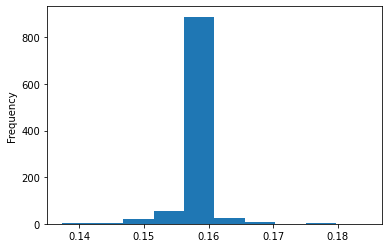

In [46]:
preds_test = pd.Series(cb.predict_proba(test_df)[:, 1])
preds_test.plot.hist()

# catboost on cleaned

In [183]:
from src.preprocessing import TextCleaner

In [194]:
cleaner = TextCleaner()
cleaner.get_params()

{'clean_email': True,
 'clean_emoji': True,
 'clean_hashtag': True,
 'clean_non_alpha': True,
 'clean_non_letter': True,
 'clean_url': True,
 'clean_user_ref': True,
 'drop_repeated': True,
 'latinize': True,
 'to_lower': True}

In [207]:
train_clean = cleaner.fit_transform(train_df['text_raw'])
train_clean = pd.DataFrame(train_clean, columns=['text_clean'])


test_clean = cleaner.transform(test_df['text_raw'])
test_clean = pd.DataFrame(test_clean, columns=['text_clean'])


train_pool_clean = Pool(train_clean, label=train_label, text_features=['text_clean'])
test_pool_clean = Pool(test_clean, label=test_label, text_features=['text_clean'])

In [206]:
params = {
    'eval_metric': 'AUC',
    'text_features': ['text_clean'],
    'metric_period': 10,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_clean, y=train_label, eval_set=(test_clean, test_label))

Learning rate set to 0.056019
0:	test: 0.4994220	best: 0.4994220 (0)	total: 58ms	remaining: 57.9s
10:	test: 0.5094427	best: 0.5094427 (10)	total: 783ms	remaining: 1m 10s
20:	test: 0.4975153	best: 0.5094427 (10)	total: 1.61s	remaining: 1m 15s
30:	test: 0.4803080	best: 0.5094427 (10)	total: 2.51s	remaining: 1m 18s
40:	test: 0.4903977	best: 0.5094427 (10)	total: 3.22s	remaining: 1m 15s
50:	test: 0.4751833	best: 0.5094427 (10)	total: 4.09s	remaining: 1m 16s
60:	test: 0.4543309	best: 0.5094427 (10)	total: 4.93s	remaining: 1m 15s
70:	test: 0.4603011	best: 0.5094427 (10)	total: 5.72s	remaining: 1m 14s
80:	test: 0.4855880	best: 0.5094427 (10)	total: 6.55s	remaining: 1m 14s
90:	test: 0.4906738	best: 0.5094427 (10)	total: 7.4s	remaining: 1m 13s
100:	test: 0.4909326	best: 0.5094427 (10)	total: 8.23s	remaining: 1m 13s
110:	test: 0.4980200	best: 0.5094427 (10)	total: 9.02s	remaining: 1m 12s
120:	test: 0.4948753	best: 0.5094427 (10)	total: 9.85s	remaining: 1m 11s
130:	test: 0.4845829	best: 0.5094427

## summ

In [208]:
metrics = ['AUC', 'Accuracy', 'F1', 'Precision', 'Recall']

eval_train = pd.Series({k: v[-1] for k, v in cb.eval_metrics(train_pool_clean,  metrics).items()})
eval_test = pd.Series({k: v[-1] for k, v in cb.eval_metrics(test_pool_clean,  metrics).items()})

pd.DataFrame(zip(eval_train, eval_test), columns=['train', 'test'], index=eval_train.index)

,train,test
AUC,0.526524,0.509443
Accuracy,0.915239,0.865866
F1,0.000000,0.000000
Precision,1.000000,1.000000
Recall,0.000000,0.000000


<AxesSubplot:ylabel='Frequency'>

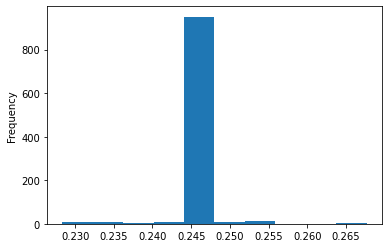

In [209]:
preds_test = pd.Series(cb.predict_proba(test_clean)[:, 1])
preds_test.plot.hist()

In [200]:
train_clean.nunique()

9488